In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.activations as act
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, Concatenate, AveragePooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Reshape, Flatten, Dense, Add, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as split
from keras.callbacks import LearningRateScheduler
import random
from tensorflow.keras import regularizers

In [ ]:
def bottle_neck(x, filters, kernels, times, first_block = 0, skip = 'projection'):
    for time in range(times):
        for i in range(len(filters)):
            skip_connection = x
            if i == 0 and time == 0:
                x = Conv2D(filters[i], kernels[i], padding='same', strides = 2)(x)
                if skip == 'projection':
                    skip_connection = Conv2D(filters[i], kernel_size = 1, padding='valid', strides = 2)(skip_connection)
                else:
                    print(skip_connection.shape)
                    skip_connection = AveragePooling2D(strides = 2, padding = 'same')(skip_connection)
                    pad_channels = x.shape[3] - skip_connection.shape[3]
                    if pad_channels > 0:
                        temp = skip_connection
                        side = int(pad_channels / 2)
                        temp = temp * 0
                        skip_connection = tf.concat([temp, skip_connection], axis = -1)
                        skip_connection = tf.concat([skip_connection, temp], axis = -1)
                        skip_connection = skip_connection[:,:,:,side:-side]
            
            else:
                x = Conv2D(filters[i], kernels[i], padding='same')(x)
            x = BatchNormalization()(x)
            inp = [x,skip_connection]
            added = Add()(inp)
            #added = tf.keras.layers.add(inp)
            x = act.relu(added)
    return x

In [ ]:
def conv_block(inps, convs):
    x = inps
    for conv in convs:
        initializer = tf.keras.initializers.HeNormal()
        x = Conv2D(conv['filter'], conv['kernel'], conv['strides'], conv['padding'], kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = act.relu(x)
    return x

#### input size (224x224x3)

In [ ]:
def resnet_18():
    input_image = Input(shape = (224, 224, 3))
    x = conv_block(input_image, [{'filter':64, 'kernel':7, 'strides':2, 'padding':'same'}])
    x = MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

    x = bottle_neck(x, [64, 64], [3, 3], 2)
    #x = bottle_neck(x, [128, 128], [3, 3], 2)
    #x = bottle_neck(x, [256, 256], [3, 3], 2)
    #x = bottle_neck(x, [512, 512], [3, 3], 2)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation = 'softmax')(x)

    x = Model(inputs = input_image, outputs = x)
    return x

In [ ]:
model_resnet_18 = resnet_18()
model_resnet_18.summary()

In [ ]:
x = tf.random.uniform((1,224,224,3))
for layer in resnet_18().layers:
    x = layer(x)
    print(layer.__class__.__name__,'output shape:\t\t',x.shape)

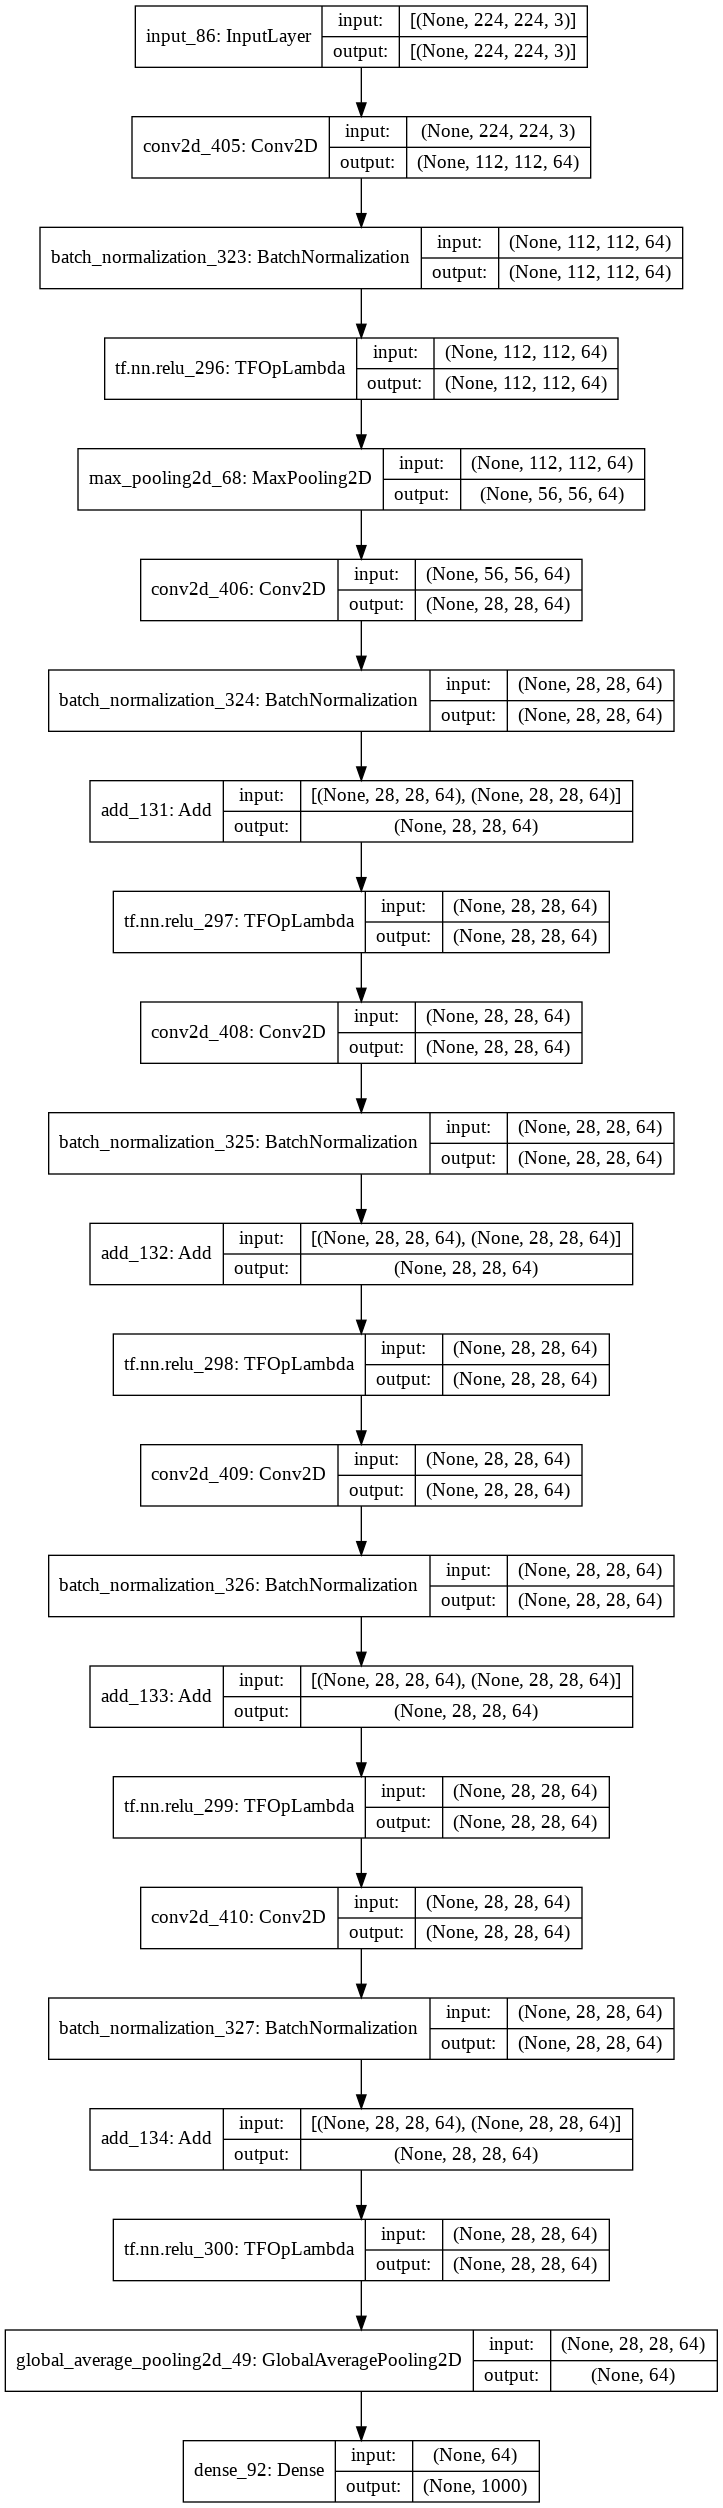

In [ ]:
tf.keras.utils.plot_model(model_resnet_18, to_file = 'model_resnet_18.png', show_shapes=True, show_layer_names=True)

In [ ]:
def resnet_34():
    input_image = Input(shape = (224, 224, 3))
    x = conv_block(input_image, [{'filter':64, 'kernel':7, 'strides':2, 'padding':'same'}])
    x = MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

    x = bottle_neck(x, [64, 64], [3, 3], 2)
    x = bottle_neck(x, [128, 128], [3, 3], 4)
    x = bottle_neck(x, [256, 256], [3, 3], 6)
    x = bottle_neck(x, [512, 512], [3, 3], 3)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation = 'softmax')(x)

    x = Model(inputs = input_image, outputs = x)
    return x

In [ ]:
model = resnet_34()
model.summary()

In [ ]:
def bottle_neck_multi(x, filters, kernels, times, first_block = 0, skip = 'projection'):
    for time in range(times):
        for i in range(len(filters)):
            skip_connection = x
            if i == 0 and time == 0:
                x = Conv2D(filters[i], kernels[i], padding='same', strides = 2)(x)
                if skip == 'projection':
                    skip_connection = Conv2D(filters[i], kernel_size = 1, padding='valid', strides = 2)(skip_connection)
                else:
                    skip_connection = AveragePooling2D(strides = 2, padding = 'same')(skip_connection)
                    pad_channels = x.shape[3] - skip_connection.shape[3]
                    if pad_channels > 0:
                        temp = skip_connection
                        side = int(pad_channels / 2)
                        temp = temp * 0
                        skip_connection = tf.concat([temp, skip_connection], axis = -1)
                        skip_connection = tf.concat([skip_connection, temp], axis = -1)
                        skip_connection = skip_connection[:,:,:,side:-side]
            else:
                x = Conv2D(filters[i], kernels[i], padding='same')(x)
            if (i == 0 and time != 0)  or i == 2:
                skip_connection = Conv2D(filters[i], kernel_size = 1, padding='same')(skip_connection)
            x = BatchNormalization()(x)
            inp = [x,skip_connection]
            added = Add()(inp)
            x = act.relu(x)
    return x

In [ ]:
def resnet_50():
    input_image = Input(shape = (224, 224, 3))
    x = conv_block(input_image, [{'filter':64, 'kernel':7, 'strides':2, 'padding':'same'}])
    x = MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

    x = bottle_neck_multi(x, [64, 64, 256], [1, 3, 1], 3)
    x = bottle_neck_multi(x, [128, 128, 512], [1, 3, 1], 4)
    x = bottle_neck_multi(x, [256, 256, 1024], [1, 3, 1], 6)
    x = bottle_neck_multi(x, [512, 512, 2048], [1, 3, 1], 3)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation = 'softmax')(x)

    x = Model(inputs = input_image, outputs = x)
    return x

In [ ]:
model = resnet_50()
model.summary()

In [ ]:
def resnet_101():
    input_image = Input(shape = (224, 224, 3))
    x = conv_block(input_image, [{'filter':64, 'kernel':7, 'strides':2, 'padding':'same'}])
    x = MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

    x = bottle_neck_multi(x, [64, 64, 256], [1, 3, 1], 3)
    x = bottle_neck_multi(x, [128, 128, 512], [1, 3, 1], 4)
    x = bottle_neck_multi(x, [256, 256, 1025], [1, 3, 1], 23)
    x = bottle_neck_multi(x, [512, 512, 2048], [1, 3, 1], 3)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation = 'softmax')(x)

    x = Model(inputs = input_image, outputs = x)
    return x

In [ ]:
model = resnet_101()
model.summary()

In [ ]:
def resnet_152():
    input_image = Input(shape = (224, 224, 3))
    x = conv_block(input_image, [{'filter':64, 'kernel':7, 'strides':2, 'padding':'same'}])
    x = MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

    x = bottle_neck_multi(x, [64, 64, 256], [1, 3, 1], 2)
    x = bottle_neck_multi(x, [128, 128, 512], [1, 3, 1], 2)
    x = bottle_neck_multi(x, [256, 256, 1024], [1, 3, 1], 2)
    x = bottle_neck_multi(x, [512, 512, 2048], [1, 3, 1], 2)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation = 'softmax')(x)

    x = Model(inputs = input_image, outputs = x)
    return x

In [ ]:
model = resnet_152()
model.summary()

In [ ]:
input1 = tf.keras.layers.Input(shape=(224,224,3))
x = Conv2D(5, 1, padding='same', strides = 2)(input1)
x = Conv2D(5, 1, padding='same', strides = 2)(x)

#added = tf.keras.layers.add([x,x])
added = tf.keras.layers.Add()([x1, x2])
added.shape

TensorShape([None, 224, 224, 8])